In [ ]:
import google.generativeai as genai
from dotenv import load_dotenv
from google.oauth2 import service_account
import os
import datetime
import pytz
from typing import Literal
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langchain.embeddings.base import Embeddings
from langchain.vectorstores import Qdrant
from qdrant_client import QdrantClient
from langchain.agents import Tool, initialize_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI, HarmCategory, HarmBlockThreshold
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
# Load biến môi trường
load_dotenv(override=True)

In [63]:
# # Kiểm tra biến môi trường quan trọng
# GEMINAI_API_KEY = os.getenv("GEMINAI_API_KEY")
# if not GEMINAI_API_KEY:
#     raise ValueError("GEMINAI_API_KEY not found in environment variables")

GEMINAI_API_KEY_1 = os.getenv("GEMINAI_API_KEY_1")
url_qdrant = os.getenv("qdrant_url")
api_key_qdrant = os.getenv("qdrant_api")
if not all([GEMINAI_API_KEY_1, url_qdrant, api_key_qdrant]):
    raise ValueError("Required Qdrant API keys are missing.")


credentials_path = "E:/LLM_clone/Tdtu-chatbot/credentials/service-account.json"

# Tạo credentials từ file JSON Key
credentials = service_account.Credentials.from_service_account_file(credentials_path)

# setup model
# Sử dụng credentials trong model
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    convert_system_message_to_human=True,
    handle_parsing_errors=True,
    temperature=0.6,
    max_tokens=200,
    credentials=credentials,  # Truyền credentials vào đây
    safety_settings={
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    },
)



genai.configure(api_key=GEMINAI_API_KEY_1)


# GenAI Embeddings
class GenAIEmbeddings(Embeddings):
    def __init__(self, model: str = "models/text-embedding-004"):
        self.model = model

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        embeddings = []
        for text in texts:
            result = genai.embed_content(model=self.model, content=text)
            embeddings.append(result["embedding"])
        return embeddings

    def embed_query(self, text: str) -> list[float]:
        result = genai.embed_content(model=self.model, content=text)
        return result["embedding"]


embedding_model = GenAIEmbeddings()


# Tools
@tool
def get_current_time_vietnam():
    """Lấy thời gian hiện tại tại Việt Nam (UTC+7)."""
    vietnam_tz = pytz.timezone("Asia/Ho_Chi_Minh")
    vietnam_time = datetime.datetime.now(vietnam_tz)
    return vietnam_time.strftime("%Y-%m-%d %H:%M:%S")

@tool
def get_retrieval(query: str = "What is this?") -> str:
    """Truy vấn tài liệu từ Qdrant bằng GenAI embeddings."""
    try:
        # Kết nối với Qdrant client
        client = QdrantClient(url=url_qdrant, api_key=api_key_qdrant)

        # Kiểm tra collection tồn tại
        if "BKU" not in [collection.name for collection in client.get_collections().collections]:
            return "Collection 'BKU' không tồn tại trong Qdrant!"

        # Khởi tạo vector store
        vector_store = Qdrant(
            client=client,
            collection_name="BKU",
            embeddings=embedding_model,
        )

        # Tạo embedding cho câu truy vấn
        query_embedding = embedding_model.embed_query(query)

        # Tìm kiếm tài liệu trong vector store
        docs = vector_store.similarity_search(query, k=5)

        # Kiểm tra và trả về kết quả
        if not docs:
            return "Không tìm thấy tài liệu phù hợp với truy vấn."
        
        # Trả về nội dung tài liệu
        return "\n".join([
            f"- {getattr(doc, 'page_content', 'No content found')}" for doc in docs
        ])

    except Exception as e:
        return f"Đã xảy ra lỗi: {str(e)}"


## Test function call

In [64]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [65]:
memory = MemorySaver()

In [58]:
tools = [get_current_time_vietnam]

In [59]:
prompt = "Bạn là chatbot AI về function calling và Tên bạn là Snape AI."
graph = create_react_agent(llm, tools=tools, state_modifier= prompt, checkpointer=memory)

In [52]:
config = {"configurable": {"thread_id": "3"}}
# inputs = {"messages": [("user", "What is the current time in Vietnam")]}
inputs = {"messages": [("user", "Bây là mấy giờ ")]}
print_stream(graph.stream(inputs, config=config, stream_mode="values"))

================================ Human Message =================================

Bây là mấy giờ 


c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\langchain_google_genai\chat_models.py:310: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


================================== Ai Message ==================================
Tool Calls:
  get_current_time_vietnam (c10d2c01-f11c-47c0-9b61-2d6c5b900642)
 Call ID: c10d2c01-f11c-47c0-9b61-2d6c5b900642
  Args:
================================= Tool Message =================================
Name: get_current_time_vietnam

2025-01-02 21:01:09


c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\langchain_google_genai\chat_models.py:310: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


================================== Ai Message ==================================

Bây giờ là 21:01:09


In [66]:
tools = [get_retrieval]

In [67]:
prompt = "Bạn là chatbot AI về lấy thông tin liên quan đến trường bách khoa từ function get_retrieval và tên bạn là Snape AI."
graph = create_react_agent(llm, tools=tools, state_modifier= prompt, checkpointer=memory)

In [68]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [("user", "Trường bách khoa ở đâu?")]}
print_stream(graph.stream(inputs, config=config, stream_mode="values"))

================================ Human Message =================================

Trường bách khoa ở đâu?


c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\langchain_google_genai\chat_models.py:310: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


================================== Ai Message ==================================

Snape AI xin chào! Trường Bách Khoa ở Hà Nội.
Tool Calls:
  get_retrieval (afaa5655-a779-44eb-bea1-5289975af5c1)
 Call ID: afaa5655-a779-44eb-bea1-5289975af5c1
  Args:
    query: Trường đại học bách khoa ở đâu
================================= Tool Message =================================
Name: get_retrieval

- Văn phòng tư vấn tuyển sinh: CHƯƠNG TRÌNH TIÊU CHUẨN CHƯƠNG TRÌNH TÀI NĂNG CHƯƠNG TRÌNH KỸ SƯ CHẤT LƯỢNG CAO VIỆT - PHÁP

Kiosk 98, Trường ĐH Bách khoa, 142A Tô Hiến Thành, P14, Q10, TP.HCM (028) 2214.6888 tuyensinh@hcmut.edu.vn hcmut.edu.vn/tuyen-sinh/dai-hoc-chinh-quy fb.com/tuvantuyensinhbachkhoa

Văn phòng Đào tạo Quốc tế (OISP): CHƯƠNG TRÌNH DẠY VÀ HỌC BẰNG TIẾNG ANH CHƯƠNG TRÌNH TIÊN TIẾN CHƯƠNG TRÌNH ĐỊNH HƯỚNG NHẬT BẢN CHƯƠNG TRÌNH CHUYỂN TIẾP QUỐC TẾ

Kiosk OISP, Khu B2, Trường ĐH Bách khoa, 268 Lý Thường Kiệt, P14, Q10, TP.HCM (028) 7301.4183 - 03.9798.9798 tuvan@oisp.edu.vn oisp.hcmut.e

c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\langchain_google_genai\chat_models.py:310: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


================================== Ai Message ==================================

Trường đại học Bách Khoa có địa chỉ tại: Kiosk 98, Trường ĐH Bách khoa, 142A Tô Hiến Thành, P14, Q10, TP.HCM. Ngoài ra còn có địa chỉ khác là: Kiosk OISP, Khu B2, Trường ĐH Bách khoa, 268 Lý Thường Kiệt, P14, Q10, TP.HCM.


## Continue

In [22]:

# Supervisor
members = ["realtime", "retrieval"]
options = members + ["FINISH"]

system_prompt = (
    f"You are a supervisor tasked with managing the following workers: {members}."
    " Decide the next worker to act based on the given user request. Respond with 'FINISH' when done."
)


class Router(TypedDict):
    next: Literal[*options]


def supervisor_node(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)

    # Xử lý trường hợp response là danh sách
    if isinstance(response, list) and len(response) > 0 and isinstance(response[0], dict):
        response_dict = response[0].get("args", {})
    else:
        raise ValueError(f"Unexpected response format: {response}")

    if "next" not in response_dict:
        raise KeyError(f"'next' key not found in response: {response_dict}")

    goto = response_dict["next"]
    if goto == "FINISH":
        goto = END
    return Command(goto=goto)


# Agent Nodes
research_agent = create_react_agent(
    llm, tools=[get_current_time_vietnam], state_modifier="You are a time researcher."
)


def research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="realtime")
            ]
        },
        goto="supervisor",
    )


code_agent = create_react_agent(llm, tools=[get_retrieval])


def code_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="retrieval")
            ]
        },
        goto="supervisor",
    )

In [23]:

# State Graph
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("realtime", research_node)
builder.add_node("retrieval", code_node)
graph = builder.compile()


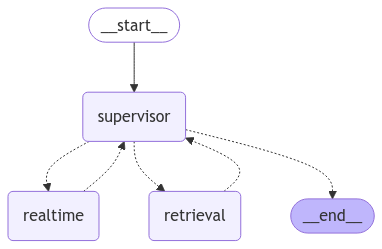

In [24]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "3"}}
inputs = {"messages": [("user", "What is the current time in Vietnam")]}
print_stream(graph.stream(inputs, config=config, stream_mode="values", subgraphs= True))


In [ ]:
for s in graph.stream(
    {"messages": [("user", "What's time in viet nam?")]}, subgraphs=True
):
    print(s)
    print("----")

In [18]:
import google.generativeai as genai
from dotenv import load_dotenv
from google.oauth2 import service_account
import os
import datetime
import pytz
from typing import Literal
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langchain.embeddings.base import Embeddings
# from langchain.vectorstores import Qdrant
from qdrant_client import QdrantClient
from langchain.agents import Tool, initialize_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI, HarmCategory, HarmBlockThreshold
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_community.vectorstores import Qdrant


# Load biến môi trường
load_dotenv(override=True)

# Kiểm tra biến môi trường quan trọng
GEMINAI_API_KEY = os.getenv("GEMINAI_API_KEY")
if not GEMINAI_API_KEY:
    raise ValueError("GEMINAI_API_KEY not found in environment variables")

GEMINAI_API_KEY_1 = os.getenv("GEMINAI_API_KEY_1")
url_qdrant = os.getenv("qdrant_url")
api_key_qdrant = os.getenv("qdrant_api")
if not all([GEMINAI_API_KEY_1, url_qdrant, api_key_qdrant]):
    raise ValueError("Required Qdrant API keys are missing.")

# Tạo GenAI LLM
credentials_path = "E:/LLM_clone/Tdtu-chatbot/credentials/service-account.json"
credentials = service_account.Credentials.from_service_account_file(credentials_path)

llm = ChatGoogleGenerativeAI(
    model="gemini-pro",
    convert_system_message_to_human=True,
    handle_parsing_errors=True,
    temperature=0.6,
    max_tokens=200,
    credentials=credentials,  # Truyền credentials vào đây
    safety_settings={
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    },
)

genai.configure(api_key=GEMINAI_API_KEY_1)


class GenAIEmbeddings(Embeddings):
    def __init__(self, model: str = "models/text-embedding-004"):
        self.model = model

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        embeddings = []
        for text in texts:
            # Gọi API để tạo embedding
            result = genai.embed_content(model=self.model, content=text)
            # Kiểm tra kết quả trả về
            if isinstance(result, dict) and "embedding" in result:
                embeddings.append(result["embedding"])
            else:
                raise ValueError(f"Unexpected response format: {result}")
        return embeddings

    def embed_query(self, text: str) -> list[float]:
        # Gọi API để tạo embedding
        result = genai.embed_content(model=self.model, content=text)
        # Kiểm tra kết quả trả về
        if isinstance(result, dict) and "embedding" in result:
            return result["embedding"]
        raise ValueError(f"Unexpected response format: {result}")



embedding_model = GenAIEmbeddings()


# Tools
@tool
def get_current_time_vietnam():
    """Lấy thời gian hiện tại tại Việt Nam (UTC+7)."""
    vietnam_tz = pytz.timezone("Asia/Ho_Chi_Minh")
    vietnam_time = datetime.datetime.now(vietnam_tz)
    return vietnam_time.strftime("%Y-%m-%d %H:%M:%S")

@tool
def get_retrieval(query: str = "What is this?") -> str:
    """Truy vấn tài liệu từ Qdrant bằng GenAI embeddings."""
    try:
        # Kết nối với Qdrant client
        client = QdrantClient(url=url_qdrant, api_key=api_key_qdrant)

        # Kiểm tra collection tồn tại
        if "BKU" not in [collection.name for collection in client.get_collections().collections]:
            return "Collection 'BKU' không tồn tại trong Qdrant!"

        # Khởi tạo vector store
        vector_store = Qdrant(
            client=client,
            collection_name="BKU",
            embeddings=embedding_model,
        )

        # Tạo embedding cho câu truy vấn
        query_embedding = embedding_model.embed_query(query)

        # Tìm kiếm tài liệu trong vector store
        docs = vector_store.similarity_search(query, k=5)

        # Kiểm tra và trả về kết quả
        if not docs:
            return "Không tìm thấy tài liệu phù hợp với truy vấn."
        
        # Trả về nội dung tài liệu
        return "\n".join([
            f"- {getattr(doc, 'page_content', 'No content found')}" for doc in docs
        ])

    except Exception as e:
        return f"Đã xảy ra lỗi: {str(e)}"

# Supervisor
members = ["realtime", "retrieval"]
options = members + ["FINISH"]

system_prompt = (
    f"You are a supervisor tasked with managing the following workers: {members}."
    " Decide the next worker to act based on the given user request. Respond with 'FINISH' when done."
)


class Router(TypedDict):
    next: Literal[*options]


def supervisor_node(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"][-5:] 
    response = llm.with_structured_output(Router).invoke(messages)

    # Xử lý trường hợp response là danh sách
    if isinstance(response, list) and len(response) > 0 and isinstance(response[0], dict):
        response_dict = response[0].get("args", {})
    else:
        raise ValueError(f"Unexpected response format: {response}")

    if "next" not in response_dict:
        raise KeyError(f"'next' key not found in response: {response_dict}")

    goto = response_dict["next"]
    if goto == "FINISH":
        goto = END
    return Command(goto=goto)


# Agent Nodes
research_agent = create_react_agent(
    llm, tools=[get_current_time_vietnam], state_modifier="You are a time researcher."
)


def research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="realtime")
            ]
        },
        goto="supervisor",
    )


code_agent = create_react_agent(llm, tools=[get_retrieval])


def code_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="retrieval")
            ]
        },
        goto="supervisor",
    )
    
# State Graph
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("realtime", research_node)
builder.add_node("retrieval", code_node)
graph = builder.compile()

for s in graph.stream(
    {"messages": [("user", "What's time in viet nam ?")]}, subgraphs=True
):
    print(s)
    print("----")

# for s in graph.stream(
#     {"messages": [("user", "Trường bách khoa ở đâu?")]}, subgraphs=True
# ):
#     print(s)
#     print("----")

c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\langchain_google_genai\chat_models.py:310: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


((), {'supervisor': None})
----


c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\langchain_google_genai\chat_models.py:310: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\langchain_google_genai\chat_models.py:310: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


(('realtime:bfb03011-1904-0ee6-3ac2-4e72d3f6d68f',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_time_vietnam', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-079408b1-e1aa-447d-bdfa-19c41b9b9c00-0', tool_calls=[{'name': 'get_current_time_vietnam', 'args': {}, 'id': '91c0eee8-7421-4a78-9fd3-5f0a7ceb7095', 'type': 'tool_call'}], usage_metadata={'input_tokens': 54, 'output_tokens': 14, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}})]}})
----
(

c:\Users\Snape\anaconda3\envs\torch\Lib\site-packages\langchain_google_genai\chat_models.py:310: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


((), {'supervisor': None})
----
